# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import time

#for viz
import matplotlib.pyplot as plt
%matplotlib inline

#ddpg agent
from ddpg_agent import Agent

In [2]:
#Choose which environment to run
env_v = 2

In [3]:
if env_v == 1:
    env = UnityEnvironment(file_name='Reacher.app')
elif env_v == 2:
    env = UnityEnvironment(file_name='Reacher20.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [6]:
def plot(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Average Score')
    plt.xlabel('Episode #')
    plt.show()

In [7]:
from datetime import datetime
solved_actor_name = datetime.now().strftime('%m%d_%H%M%S')+"_actor.pth"
solved_critic_name = datetime.now().strftime('%m%d_%H%M%S')+"_critic.pth"
solved_scores = datetime.now().strftime('%m%d_%H%M%S')+"scores.csv"

In [8]:
def ddpg(episodes=150, max_t=1000, window=100):
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
    scores_window = deque(maxlen=window)
    scores_all = []
    actor_losses = []
    critic_losses = []
    decay_lr_episodes = 10
    for i in range(episodes):
        start_time = time.time()
        t = 0
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        while True and t < max_t: #for each time step
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            for state,action,reward,next_state,done in zip(states,actions,rewards,next_states,dones):
                agent.step(state,action,reward,next_state,done,t)
            states = next_states                               # roll over states to next time step
            t += 1 #increment time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        scores_window.append(np.mean(scores))
        scores_all.append(np.mean(scores))
        #Decay the learning rate every n episodes
        if i > 1 and i % decay_lr_episodes == 0:
            agent.decay_lr()
        torch.save(agent.actor_local.state_dict(), "_chkpt_actor.pth")
        torch.save(agent.critic_local.state_dict(), "_chkpt_critic.pth")
        np.savetxt("_scores.csv", scores, delimiter=',')   # solved scores
        print('E: {}\tEpisode mean: {:.2f}\twindow mean: {:.2f}\tep max: {:.2f}\ttime: {:.0f}\tt:{:.0f}'.format(i+1, np.mean(scores), np.mean(scores_window), np.max(scores), (time.time()-start_time), t))
        if np.mean(scores_window) >= 30.0 and i >= 101:
            print('\rSolved! Episode: {}\twindow mean:{:.2f}'.format(i+1,np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), solved_actor_name)
            torch.save(agent.critic_local.state_dict(), solved_critic_name)
            break
        if i == 50 and np.mean(scores_window) < 0.5:
            print('\rBelow 0.5 at episode 50, stopping training')
            break
            
    return scores_all, scores_window

## Reacher environment v2 - 20 agents

In [9]:
scores, scores_window = ddpg(episodes=500, max_t=3000, window=100)
plot(scores)

E: 1	Episode mean: 1.12	window mean: 1.12	all mean: 1.12	ep max: 2.02	time: 261	t:1001
E: 2	Episode mean: 2.05	window mean: 1.59	all mean: 1.59	ep max: 4.41	time: 555	t:1001
E: 3	Episode mean: 3.68	window mean: 2.28	all mean: 2.28	ep max: 5.43	time: 850	t:1001
E: 4	Episode mean: 5.24	window mean: 3.02	all mean: 3.02	ep max: 6.79	time: 1153	t:1001
E: 5	Episode mean: 4.98	window mean: 3.42	all mean: 3.42	ep max: 11.45	time: 1455	t:1001
E: 6	Episode mean: 5.14	window mean: 3.70	all mean: 3.70	ep max: 8.86	time: 2264	t:1001
E: 7	Episode mean: 5.29	window mean: 3.93	all mean: 3.93	ep max: 9.09	time: 3176	t:1001
E: 8	Episode mean: 6.30	window mean: 4.23	all mean: 4.23	ep max: 11.74	time: 3490	t:1001
E: 9	Episode mean: 7.95	window mean: 4.64	all mean: 4.64	ep max: 11.82	time: 3806	t:1001
E: 10	Episode mean: 8.76	window mean: 5.05	all mean: 5.05	ep max: 12.79	time: 4123	t:1001
E: 11	Episode mean: 10.68	window mean: 5.56	all mean: 5.56	ep max: 22.67	time: 4846	t:1001
E: 12	Episode mean: 10.48	w

E: 90	Episode mean: 35.21	window mean: 29.48	all mean: 29.48	ep max: 38.75	time: 80626	t:1001
E: 91	Episode mean: 37.55	window mean: 29.57	all mean: 29.57	ep max: 39.10	time: 81347	t:1001
E: 92	Episode mean: 37.83	window mean: 29.66	all mean: 29.66	ep max: 39.58	time: 82012	t:1001
E: 93	Episode mean: 37.62	window mean: 29.75	all mean: 29.75	ep max: 39.50	time: 84940	t:1001
E: 94	Episode mean: 35.79	window mean: 29.81	all mean: 29.81	ep max: 39.08	time: 85374	t:1001
E: 95	Episode mean: 36.88	window mean: 29.89	all mean: 29.89	ep max: 39.62	time: 85805	t:1001
E: 96	Episode mean: 35.26	window mean: 29.94	all mean: 29.94	ep max: 38.78	time: 86760	t:1001
E: 97	Episode mean: 36.73	window mean: 30.01	all mean: 30.01	ep max: 38.91	time: 88012	t:1001
Solved! Episode: 97	window mean:30.01
E: 98	Episode mean: 36.55	window mean: 30.08	all mean: 30.08	ep max: 39.19	time: 88677	t:1001
Solved! Episode: 98	window mean:30.08
E: 99	Episode mean: 36.81	window mean: 30.15	all mean: 30.15	ep max: 39.39	tim

KeyboardInterrupt: 

E: 1	Episode mean: 0.75	window mean: 0.75	ep max: 1.79	time: 209	t:1001
E: 2	Episode mean: 1.47	window mean: 1.11	ep max: 2.97	time: 236	t:1001
E: 3	Episode mean: 1.97	window mean: 1.39	ep max: 3.21	time: 238	t:1001
E: 4	Episode mean: 2.45	window mean: 1.66	ep max: 4.22	time: 240	t:1001
E: 5	Episode mean: 2.80	window mean: 1.89	ep max: 4.35	time: 243	t:1001
E: 6	Episode mean: 3.20	window mean: 2.11	ep max: 5.34	time: 728	t:1001
E: 7	Episode mean: 3.65	window mean: 2.33	ep max: 5.03	time: 1184	t:1001
E: 8	Episode mean: 3.11	window mean: 2.43	ep max: 4.85	time: 764	t:1001
E: 9	Episode mean: 3.53	window mean: 2.55	ep max: 5.50	time: 943	t:1001
E: 10	Episode mean: 5.07	window mean: 2.80	ep max: 8.45	time: 1173	t:1001
New lrs... 0.0009000000000000001 0.0009000000000000001
E: 11	Episode mean: 6.06	window mean: 3.10	ep max: 12.04	time: 753	t:1001
E: 12	Episode mean: 6.99	window mean: 3.42	ep max: 10.13	time: 205	t:1001
E: 13	Episode mean: 7.49	window mean: 3.73	ep max: 12.63	time: 209	t:1001


E: 102	Episode mean: 38.34	window mean: 29.22	ep max: 39.37	time: 1173	t:1001
E: 103	Episode mean: 37.37	window mean: 29.58	ep max: 39.17	time: 1155	t:1001
E: 104	Episode mean: 37.50	window mean: 29.93	ep max: 39.37	time: 1200	t:1001
E: 105	Episode mean: 35.05	window mean: 30.25	ep max: 37.75	time: 788	t:1001
Solved! Episode: 105	window mean:30.25


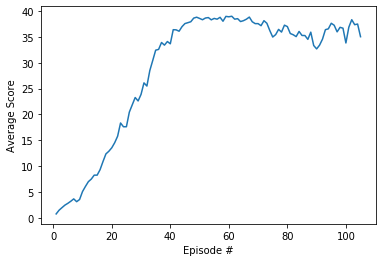

In [9]:
scores, scores_window = ddpg(episodes=500, max_t=3000, window=100)
np.savetxt(solved_scores, scores, delimiter=',')   # solved scores
plot(scores)

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
agent.actor_local.load_state_dict(torch.load('0710_200757_actor.pth'))
agent.critic_local.load_state_dict(torch.load('0710_200757_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
agent.reset()

for t in range(1000):
    actions = agent.act(env_info.vector_observations, add_noise=False)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]
    if np.any(env_info.local_done):
        break 
